# Prepare the synthetic test cases

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np

from geone.img import readImageGslib, writeImageGslib, sampleFromImage, pointSetToImage
from geone.img import writePointSetGslib, readPointSetGslib
from geone.imgplot import drawImage2D
from geone.deesseinterface import DeesseInput, deesseRun

In [25]:
DATA_DIR = 'data_roussillon/'
SAMPLES_DIR = DATA_DIR

### Synthetic realities 

In [8]:
def sample_and_write_gslib(image, size, seed, name):
        sampled_point_set = sampleFromImage(image, size=size, seed=SEED+i)
        writePointSetGslib(sampled_point_set,
                                     SAMPLES_DIR+'sample_{name}_{size}.gslib'.format(name=name, size=size))

## Roussillon: synthetic test case

In [9]:
COLOR_SCHEME_ROUSSILLON = [ 
        [x/255 for x in [166,206,227]],
        [x/255 for x in [178,223,138]],   
        [x/255 for x in [31,120,180]],
        [x/255 for x in [51,160,44]],
      ]
LEGEND = ['alluvial fan', 'flood plain', 'splay', 'river bed']

### Training image

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fc6ebb81c40>)

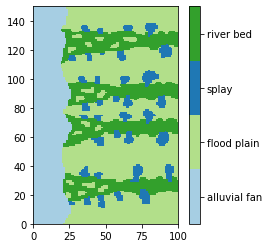

In [10]:
ti_true = readImageGslib(DATA_DIR+'trueTI.gslib')
drawImage2D(ti_true, categ=True, categCol=COLOR_SCHEME_ROUSSILLON, cticklabels=LEGEND)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fc6ebc54340>)

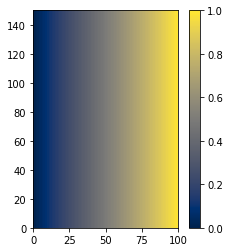

In [11]:
drawImage2D(ti_true, iv=1, cmap='cividis', vmin=0.0, vmax=1.0)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fc6e98bca60>)

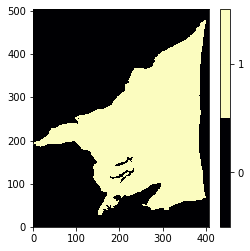

In [13]:
mask = readImageGslib(DATA_DIR+'mask.gslib')
drawImage2D(mask, categ=True, cmap='magma')

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fc6e97e7e50>)

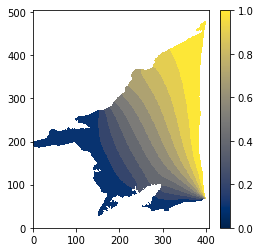

In [14]:
trend = readImageGslib(DATA_DIR+'trend.gslib')
drawImage2D(trend, cmap='cividis', vmin=0.0, vmax=1.0, excludedVal=-9999999)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7fc6e869e5b0>)

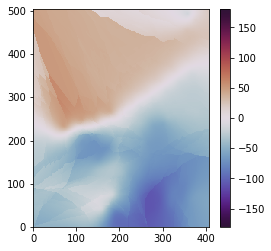

In [15]:
# Orientation
im_angle = readImageGslib(DATA_DIR+'orientation.gslib')
drawImage2D(im_angle, cmap='twilight_shifted', vmin=-180, vmax=180)

### Synthetic reality

In [51]:
nx, ny, nz = mask.nx, mask.ny, mask.nz      # number of cells
sx, sy, sz = mask.sx, mask.sy, mask.sz      # cell unit
ox, oy, oz = mask.ox, mask.oy, mask.oz      # origin (corner of the "first" grid cell)

deesse_input_roussilon = DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=2, varname=['Facies', 'trend'],
    nTI=1, TI=ti_true,
    mask=mask.val,
    rotationUsage=1,            # use rotation without tolerance
    rotationAzimuthLocal=True,  #    rotation according to azimuth: local
    rotationAzimuth=im_angle.val[0,:,:,:],      #    rotation azimuth: map of values
    dataImage=trend,
    outputVarFlag=[True, False],
    distanceType=[0,1],
    nneighboringNode=[50,1],
    distanceThreshold=[0.2, 0.2],
    maxScanFraction=0.5,
    npostProcessingPathMax=1,
    seed=201912,
    nrealization=1)

In [52]:
roussillon_simulation = deesseRun(deesse_input=deesse_input_roussilon, nthreads=1)['sim'][0]

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210112 / OpenMP 1 thread(s)]
Deesse run complete

Warnings encountered (2 times in all):
#  1: WARNING 00040: conditioning value(s) has(have) been removed (in the non-simulated part of the mask!)
#  2: WARNING 00003: training image values of a variable have been rescaled (linearly) to cover the range of conditioning data values


### Sample synthetic observation set

In [53]:
point_set_roussillon_600 = sampleFromImage(roussillon_simulation, size=600, seed=20191201, mask=mask)

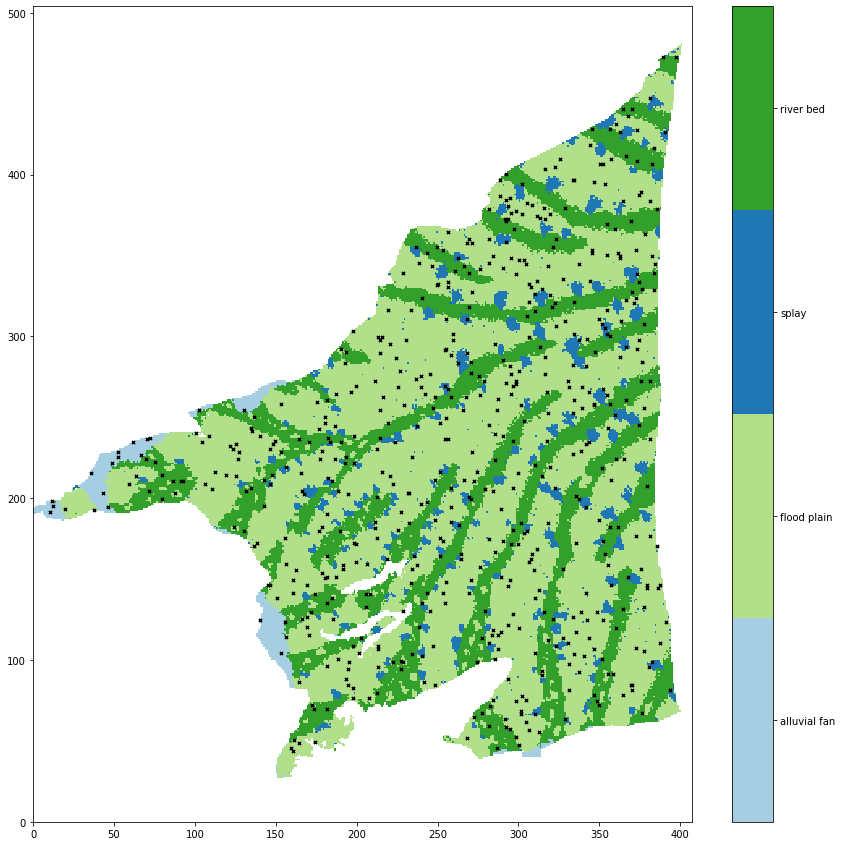

In [58]:
plt.figure(figsize=(15,15))
drawImage2D(roussillon_simulation,  categ=True, categColbad='white', categCol=COLOR_SCHEME_ROUSSILLON, cticklabels=LEGEND)
plt.scatter(point_set_roussillon_600.x(), point_set_roussillon_600.y(), marker= 'x', s=10, c='black')

In [59]:
writePointSetGslib(point_set_roussillon_600, SAMPLES_DIR+'roussillon_observations_600.gslib')

## Figures for publication

In [31]:
## Benchmark test case
FONT_SIZE = 16
FIG_DIR = 'figures/'
DPI = 600

import matplotlib

matplotlib.rcParams["image.interpolation"] = None
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Training image selection

In [32]:
def ti_selection_plot(image, filename, title, colorbar=True):
    plt.figure(figsize=(5,6))
    drawImage2D(image,   title=title,
                removeColorbar=not colorbar,
                              categ=True,
                              categColbad='white',
                              categCol=COLOR_SCHEME_BINARY,
                              title_fontsize=FONT_SIZE+2,
                              cticklabels_fontsize=FONT_SIZE,
                              xlabels_fontsize=FONT_SIZE,
                              ylabels_fontsize=FONT_SIZE,
                              xticklabels = [0,100],
                              yticklabels = [0, 100],
                              xticklabels_fontsize=FONT_SIZE,
                              yticklabels_fontsize=FONT_SIZE,
                              xticks=[0,100],
                              yticks=[0,100],
                              ylabel_rotation=0,
                
                             )
    plt.savefig(filename, dpi=DPI)
    #!convert -trim $filename $filename
    !pdfcrop $filename $filename

### Roussillon parameter selection

In [33]:
EXCLUDED_VAL = -9999999

#### Area with the trend and orientation

In [34]:
def roussillon_plot(image, filename, title, cmap, vmin, vmax, cticks, cticklabels, colorbar=True, categ=False, iv=0):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0.05, right=0.9)
    xmin, xmax = [int(x) for x in [image.xmin(), image.xmax()]]
    ymin, ymax = [int(y) for y in [image.ymin(), image.ymax()]]
    drawImage2D(image, iv=iv, excludedVal=EXCLUDED_VAL, cmap=cmap, vmin=vmin, vmax=vmax, title=title,
                removeColorbar=not colorbar,
                categ=categ,
                categCol=COLOR_SCHEME_ROUSSILLON,
                title_fontsize=FONT_SIZE+2,
                cticklabels_fontsize=FONT_SIZE,
                xlabels_fontsize=FONT_SIZE,
                ylabels_fontsize=FONT_SIZE,
                xticklabels = [xmin, xmax],
                yticklabels = [ymin, ymax],
                xticklabels_fontsize=FONT_SIZE,
                yticklabels_fontsize=FONT_SIZE,
                xticks=[xmin, xmax],
                yticks=[ymin, ymax],
                cticks=cticks,
                cticklabels=cticklabels,
                ylabel_rotation=0,
               )
    plt.savefig(filename, dpi=DPI)
    #!convert -trim $filename $filename
    !pdfcrop $filename $filename

/bin/bash: pdfcrop: command not found


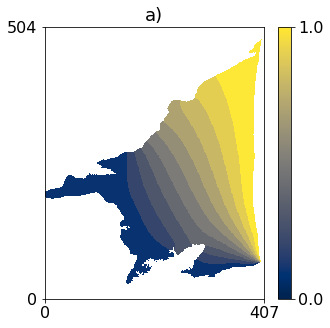

In [35]:
roussillon_plot(trend, filename=FIG_DIR+'trend.pdf', title='a)', cmap='cividis', vmin=0.0, vmax=1.0, cticks=[0.0, 1.0], cticklabels=[0.0, 1.0])

In [36]:
# In order to limit the orientation over the domain, we must tweak the array values
# We create copy of the orientation and put values outside mask to exclude_value
im_angle_plot = copy.deepcopy(im_angle)

# Iterate over the orientation array and the mask simultaneously and modify in-place
with np.nditer(im_angle_plot.val[0:1,:], op_flags=['readwrite']) as iterator:
    for angle_el, mask_el in zip(iterator, np.nditer(mask.val.flatten())):
        if mask_el == 0:
            angle_el[...] = EXCLUDED_VAL

/bin/bash: pdfcrop: command not found


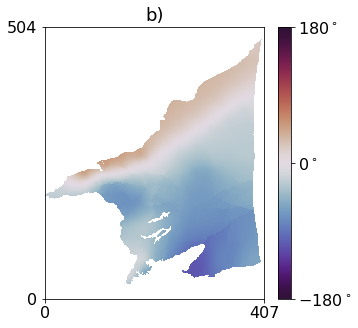

In [37]:
roussillon_plot(im_angle_plot, filename=FIG_DIR+'orientation.pdf', title='b)', cmap='twilight_shifted', vmin=-180, vmax=180, cticks=[-180, 0, 180], cticklabels=['$-180^\circ$','$0^\circ$', '$180^\circ$'])

#### Training images

In [38]:
def roussillon_cat_plot(image, filename, title, colorbar=True):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0.05, right=0.9)
    xmin, xmax = [int(x) for x in [image.xmin(), image.xmax()]]
    ymin, ymax = [int(y) for y in [image.ymin(), image.ymax()]]
    drawImage2D(image, excludedVal=EXCLUDED_VAL,
                title=title,
                removeColorbar=not colorbar,
                categ=True,
                categCol=COLOR_SCHEME_ROUSSILLON,
                cticklabels=LEGEND,
                title_fontsize=FONT_SIZE+2,
                cticklabels_fontsize=FONT_SIZE,
                xlabels_fontsize=FONT_SIZE,
                ylabels_fontsize=FONT_SIZE,
                xticklabels = [xmin, xmax],
                yticklabels = [ymin, ymax],
                xticklabels_fontsize=FONT_SIZE,
                yticklabels_fontsize=FONT_SIZE,
                xticks=[xmin, xmax],
                yticks=[ymin, ymax],
                ylabel_rotation=0,
               )
    plt.savefig(filename, dpi=DPI, bbox_inches="tight")
    !pdfcrop $filename $filename
    #!convert -trim $filename $filename

/bin/bash: pdfcrop: command not found


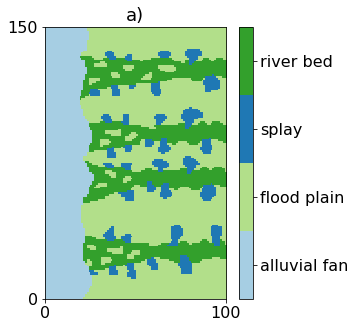

In [39]:
roussillon_cat_plot(ti_true, filename=FIG_DIR+'ti_true.pdf', title='a)')

/bin/bash: pdfcrop: command not found


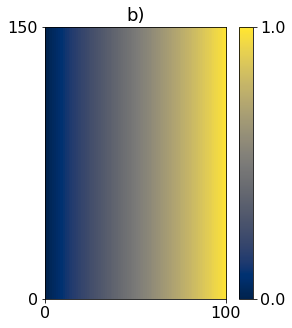

In [40]:
roussillon_plot(ti_true, filename=FIG_DIR+'ti_true_trend.pdf', title='b)', cmap='cividis', vmin=0.0, vmax=1.0, cticks=[0.0, 1.0], cticklabels=[0.0, 1.0], iv=1)

/bin/bash: pdfcrop: command not found


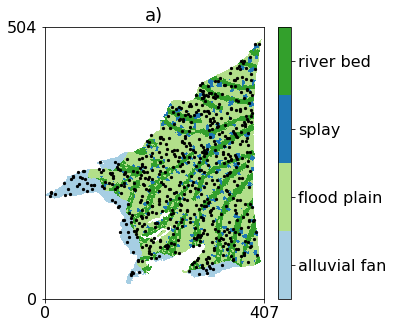

In [45]:
image = roussillon_simulation

for nsamples, title in zip(['600'], ['a)']):
    filename = FIG_DIR + "roussillon_observations_{}.pdf".format(nsamples)
    point_set_roussillon = readPointSetGslib(SAMPLES_DIR+"roussillon_observations_{}.gslib".format(nsamples))
    #image = pointSetToImage(point_set_roussillon, image.nx, image.ny, image.nz)
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0.05, right=0.9)
    xmin, xmax = [int(x) for x in [image.xmin(), image.xmax()]]
    ymin, ymax = [int(y) for y in [image.ymin(), image.ymax()]]
    if nsamples == '600':
        # set to False if you want colorbar with 3rd inage
        removeColorbar = False
    else:
        removeColorbar = True
    drawImage2D(image, excludedVal=EXCLUDED_VAL,
                title=title,
                removeColorbar=removeColorbar,
                categ=True,
                categColbad='white',
                categCol=COLOR_SCHEME_ROUSSILLON,
                cticklabels=LEGEND,
                title_fontsize=FONT_SIZE+2,
                cticklabels_fontsize=FONT_SIZE,
                xlabels_fontsize=FONT_SIZE,
                ylabels_fontsize=FONT_SIZE,
                xticklabels = [xmin, xmax],
                yticklabels = [ymin, ymax],
                xticklabels_fontsize=FONT_SIZE,
                yticklabels_fontsize=FONT_SIZE,
                xticks=[xmin, xmax],
                yticks=[ymin, ymax],
                ylabel_rotation=0,
               )
    plt.scatter(point_set_roussillon.x(), point_set_roussillon.y(), marker= 'o', s=5, c='black')
    plt.savefig(filename, dpi=DPI, bbox_inches="tight")
    #!convert -trim $filename $filename
    !pdfcrop $filename $filename